<a href="https://colab.research.google.com/github/Yun5141/comp0036/blob/master/FootballResultPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction [*Terry*]

# 2. Data Import  [*Yun*]

We first import all the packages that will be used in the code:

In [0]:
import pandas as pd 

import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

#!pip3 install geopy
from geopy.distance import geodesic 
from geopy.distance import great_circle 

#!pip3 install sklearn
import sklearn
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


And then the data sets from our github repository (https://github.com/Yun5141/comp0036):

In [0]:
# training data set
url="https://raw.githubusercontent.com/Yun5141/comp0036/master/data/epl-training.csv"
raw_training_data=pd.read_csv(url)

# test set
url = 'https://raw.githubusercontent.com/Yun5141/comp0036/master/data/epl-test.csv'
rawData_toPred = pd.read_csv(url)

# 2019 up-to-date data (from http://www.football-data.co.uk)
url = 'https://raw.githubusercontent.com/Yun5141/comp0036/master/data/epl2019.csv'
rawData_2019_uptodate = pd.read_csv(url)

# geometric information of teams
# to calculate the distance needed to travel for the away team
url = "https://raw.githubusercontent.com/Yun5141/comp0036/master/data/stadiums-with-GPS-coordinates.csv"
geometricData = pd.read_csv(url)

# 3. Data Transformation & Exploration [*Yun*]

### 3.1 Initial Data Exploration

We first visualize the raw training data and find that:
- The shape of the dataframe is 4180 rows x 73 columns, but some columns are empty and unamed.
- There are two different date formats, "%d/%m/%y" and "%d/%m/%Y".
- The involved data is from 2008-08-16 to 2019-05-12 (i.e. there are totally 11 seasons).

In [163]:
raw_training_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,M Atkinson,13,7,5,2,3,11,4,1,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4176,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,J Moss,26,13,10,4,9,6,11,2,3,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4177,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,L Probert,10,10,3,3,8,6,4,3,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4178,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,A Marriner,11,17,3,9,10,13,7,4,0,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We drop the unamed columns and find now the shape of the dataframe is 4180 rows x 22 columns.

In [164]:
raw_training_data = raw_training_data[raw_training_data.columns[~raw_training_data.columns.str.contains('Unnamed:')]]
raw_training_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,M Atkinson,13,7,5,2,3,11,4,1,0,2,0,0
4176,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,J Moss,26,13,10,4,9,6,11,2,3,3,0,0
4177,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,L Probert,10,10,3,3,8,6,4,3,0,1,0,0
4178,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,A Marriner,11,17,3,9,10,13,7,4,0,2,0,0


##### 3.1.1 Invalid data

We then check if there are rows containing None, NaN, infinite or overflowed values:

In [165]:
def removeInvalidData(data):

    # remove data which contains None
    data.dropna(axis=0, how='any',inplace=True)

    # remove data which contains NaN, infinite or overflowed number 
    indices_to_keep = ~data.isin([np.nan, np.inf, -np.inf]).any(1)
    data = data[indices_to_keep]

    return data

assert raw_training_data.shape[0] == removeInvalidData(raw_training_data).shape[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


The result indicates that there is no rows containing such values.

##### 3.1.2 Number of matches per season

The training set is of huge amount. To help learning the data, we separate the data set by seasons (from August to May) to see how many matches there are in each year.

Before splitting the data set, we need to unify the date format first.

In [166]:
# unify the different date formats and convert the type from str to timestamp  
def unifyDate(data):

    if not isinstance(data.Date[0],str):
        return

    newDate = []
    for _, matchInfo in data.iterrows():
        if len(matchInfo.Date) == 8 :
            newDate.append( pd.to_datetime(matchInfo.Date, format="%d/%m/%y" ))
        elif len(matchInfo.Date) == 10 :
            newDate.append(  pd.to_datetime(matchInfo.Date, format="%d/%m/%Y" ))
    
    data['Date'] = pd.Series(newDate).values

# to see the number of matches each year (season)
def separateData(data):
    dataframe_collection = {}

    for year in range(2008, 2019):
        dataframe_collection[year] = data[(data.Date > dt.datetime(year,8,1,0,0) ) & (data.Date < dt.datetime(year+1, 6, 1,0,0))]

    return dataframe_collection

unifyDate(raw_training_data)
collection = separateData(raw_training_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [167]:
for key in collection.keys():
    print("{} [{} rows x {} columns]".format(key,collection[key].shape[0],collection[key].shape[1]))

2008 [380 rows x 22 columns]
2009 [380 rows x 22 columns]
2010 [380 rows x 22 columns]
2011 [380 rows x 22 columns]
2012 [380 rows x 22 columns]
2013 [380 rows x 22 columns]
2014 [380 rows x 22 columns]
2015 [380 rows x 22 columns]
2016 [380 rows x 22 columns]
2017 [380 rows x 22 columns]
2018 [380 rows x 22 columns]


The result shows that the number of matches each season stays the same (380 matches per season).

##### 3.1.3 Percentage of match result

We compute the average percentage of each match result per season and also that over the 11 years.

In [0]:
def getPercentageOfMatchResult(data, matchResult):

    if matchResult not in ['H', 'A', 'D']:
        raise Exception('The second argument should only take values within [“H”,“A”,“D”]')
    
    n_wins = len(data[data.FTR == matchResult])

    return n_wins / data.shape[0]


In [169]:
# the average percentage of each match result per season
for key in collection.keys():
    print("\n" +"="*40)
    print("{} [{}]".format(key,len(collection[key])))
    print("-"*40)
    print("home team wins: {:.3f}%".format(getPercentageOfMatchResult(collection[key],"H")*100))
    print("away team wins: {:.3f}%".format(getPercentageOfMatchResult(collection[key],"A")*100))
    print("draw: {:.3f}%".format(getPercentageOfMatchResult(collection[key],"D")*100))

# the average percentage over the 11 years
print("\n" +"="*40)
print("Overall [{}]".format(len(raw_training_data)))
print("-"*40)
print("home team wins: {:.3f}%".format(getPercentageOfMatchResult(raw_training_data,"H")*100))
print("away team wins: {:.3f}%".format(getPercentageOfMatchResult(raw_training_data,"A")*100))
print("draw: {:.3f}%".format(getPercentageOfMatchResult(raw_training_data,"D")*100))



2008 [380]
----------------------------------------
home team wins: 45.526%
away team wins: 28.947%
draw: 25.526%

2009 [380]
----------------------------------------
home team wins: 50.789%
away team wins: 23.947%
draw: 25.263%

2010 [380]
----------------------------------------
home team wins: 47.105%
away team wins: 23.684%
draw: 29.211%

2011 [380]
----------------------------------------
home team wins: 45.000%
away team wins: 30.526%
draw: 24.474%

2012 [380]
----------------------------------------
home team wins: 43.684%
away team wins: 27.895%
draw: 28.421%

2013 [380]
----------------------------------------
home team wins: 47.105%
away team wins: 32.368%
draw: 20.526%

2014 [380]
----------------------------------------
home team wins: 45.263%
away team wins: 30.263%
draw: 24.474%

2015 [380]
----------------------------------------
home team wins: 41.316%
away team wins: 30.526%
draw: 28.158%

2016 [380]
----------------------------------------
home team wins: 49.211%
awa

From the result, we find that in all cases the result 'home team wins' is of the highest probability, and 'H':'A':'D' $\approx$ 5:3:2 in general.

##### 3.1.4 Relationship between attributes

Now let's take a look at the attributes:

In [170]:
raw_training_data.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR'],
      dtype='object')

We can plot a Pearson Correlation Heatmap to see the top 10 features related to the match result 'FTR':

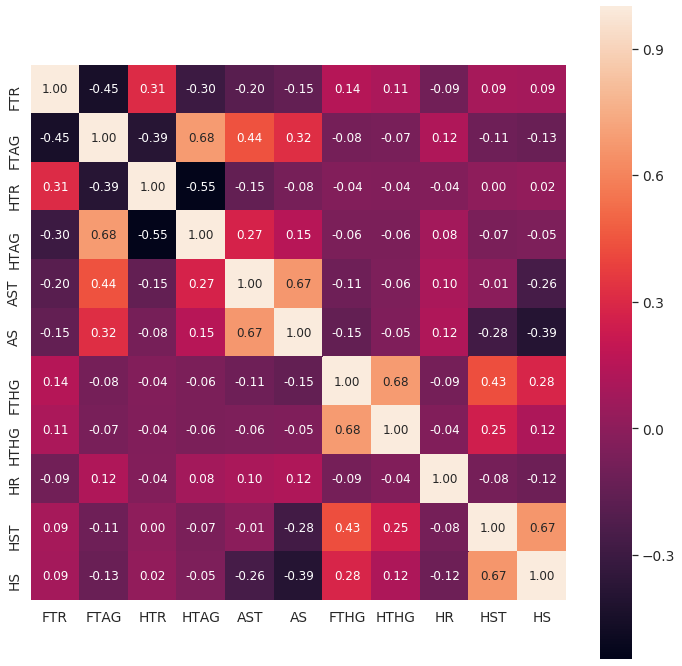

In [171]:
# plot the top 10 features related to FTR
def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = raw_training_data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = raw_training_data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)

As shown in the graph, the top 10 features are HTR, FTHG, HTHG, HST, HS, HR, AS, AST, HTAG,FTAG (ordered from the greatest to least). 

It is notable that the goal scored at full time (FTXG) & goal scored at half time (HTXG) and the total number of shots on goal (XS) & that on target (XST) are the two pairs of data which is highly correlated (>0.65).

So within the top 10 we pick the following attributes to create features:
- FTHG, FTAG -> the cumulative full time goal difference by home team and away team
- HS, AS -> the average number of shots on goal in the past 3 matches by home team and away team
- HR, AR (as features directly)

Additionally, we derive features by using:
- Date -> the delta time from last match of home team and away team
- HomeTeam, AwayTeam -> the distance needed to travel for the away team (with the help of extra data source)
- FTR -> the performance of past 3 matches of the home team and away team


In [172]:
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = raw_training_data[selectedAttributes]
training_data

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HR,AR
0,2008-08-16,Arsenal,West Brom,H,1,0,24,5,0,0
1,2008-08-16,Bolton,Stoke,H,3,1,14,8,0,0
2,2008-08-16,Everton,Blackburn,A,2,3,10,15,0,0
3,2008-08-16,Hull,Fulham,H,2,1,11,12,0,0
4,2008-08-16,Middlesbrough,Tottenham,H,2,1,14,8,0,0
...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,H,2,0,13,7,0,0
4176,2019-05-12,Man United,Cardiff,A,0,2,26,13,0,0
4177,2019-05-12,Southampton,Huddersfield,D,1,1,10,10,0,0
4178,2019-05-12,Tottenham,Everton,D,2,2,11,17,0,0


### 3.2 Feature Construction

##### 3.2.1 Cumulative full time goal difference by home team and away team

As we have found that the number of matches per season is always the same, we can simply use i % 380 == 0 to check if it is a new season and to initialize the goal difference. 

In [0]:
# calculate the cumulative goal difference (before the current match) scored by home team and away team  
def getCumulativeGoalsDiff(data):
    teams = {}
    HCGD = [] 
    ACGD = []   

    # for each match
    for i in range(len(data)):
        
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = data.iloc[i]['FTHG']
        FTAG = data.iloc[i]['FTAG']

        try:
            cgd_h = teams[data.iloc[i].HomeTeam].pop()
            cgd_a = teams[data.iloc[i].AwayTeam].pop()
        except:
            cgd_h = 0
            cgd_a = 0

        HCGD.append(cgd_h)
        ACGD.append(cgd_a)
        cgd_h = cgd_h + FTHG - FTAG
        teams[data.iloc[i].HomeTeam].append(cgd_h)
        cgd_a = cgd_a + FTAG - FTHG
        teams[data.iloc[i].AwayTeam].append(cgd_a)

    data.loc[:,'HCGD'] = pd.Series(HCGD)
    data.loc[:,'ACGD'] = pd.Series(ACGD)

    return data

##### 3.2.2 Average number of shots on goal in the past 3 matches by home team and away team

In [0]:
# calculate the average number of shots on goal in the past 3 matches by home team and away team  
def getAverageShotsOnGoalInPast3Matches(data):
    teams = {}
    HAHS = [] 
    AAHS = []   

    # for each match
    for i in range(len(data)):
        
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None]) #[3rd, 2nd, latest data]

        try:
            ahs_h = np.mean(teams[data.iloc[i].HomeTeam])
            ahs_a = np.mean(teams[data.iloc[i].AwayTeam])
        except:
            ahs_h = None
            ahs_a = None

        HAHS.append(ahs_h)
        AAHS.append(ahs_a)

        teams[data.iloc[i].HomeTeam].popleft()
        teams[data.iloc[i].HomeTeam].append(data.iloc[i].HS)

        teams[data.iloc[i].AwayTeam].popleft()
        teams[data.iloc[i].AwayTeam].append(data.iloc[i].AS)

    data.loc[:,'HAHS'] = pd.Series(HAHS)
    data.loc[:,'AAHS'] = pd.Series(AAHS)

    return data

##### 3.2.3 Delta time from last match for home team and away team  

In [0]:
# calculate the delta time from last match for home team and away team  [done]
def getDeltaTime(data):
    
    teams = {}

    HDT = []
    ADT = []

    for i in range(len(data)):
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = []    # to store last match date

        currentDate = data.iloc[i].Date

        try:
            homeLastMatchDate = teams[data.iloc[i].HomeTeam].pop()
            awayLastMatchDate = teams[data.iloc[i].AwayTeam].pop()

            hdt = (currentDate - homeLastMatchDate).days
            adt = (currentDate - awayLastMatchDate).days
        except:
            homeLastMatchDate = currentDate
            awayLastMatchDate = currentDate

            hdt = None
            adt = None

        HDT.append(hdt)
        ADT.append(adt)

        teams[data.iloc[i].HomeTeam].append(currentDate)
        teams[data.iloc[i].AwayTeam].append(currentDate)

    data.loc[:,'HDT'] = HDT
    data.loc[:,'ADT'] = ADT

    return data

##### 3.2.4 Distance needed to travel for the away team

The *geometricData* is an extra data source providing the latitude and longitude of teams

In [0]:
# get the distance needed to travel for the away team 
def getDistance(data, geometricData):
  array = []
  for x in data.iterrows():
   
    home_lat = (geometricData.loc[geometricData['Team'] == x[1].HomeTeam]).Latitude
    home_long = (geometricData.loc[geometricData['Team'] == x[1].HomeTeam]).Longitude
    home_location = (np.float32(home_lat), np.float32(home_long))
    
    away_lat = (geometricData.loc[geometricData['Team'] == x[1].AwayTeam]).Latitude
   
    away_long = (geometricData.loc[geometricData['Team'] == x[1].AwayTeam]).Longitude
    away_location = (np.float32(away_lat), np.float32(away_long))
    array.append(np.float32(geodesic(home_location, away_location).km))
  
  
  DIS = pd.Series(array)
  data.loc[:,'DIS'] = DIS

  return data

##### 3.2.5 Performances of last 3 matches of home team and away team

In [0]:
def getPerformanceOfLast3Matches(data):
    HM1 = []    # result of the last match of home team
    AM1 = []    # result of the last match of away team

    HM2 = []    # result of the 2nd last match of home team
    AM2 = []

    HM3 = []    # result of the 3rd last match of home team
    AM3 = []

    teams = {}

    for i in range(len(data)):
        
        if (i % 380 == 0):
            for name in data.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None])  #[3rd, 2nd, latest data]

        HM3.append(teams[data.iloc[i].HomeTeam].popleft())
        AM3.append(teams[data.iloc[i].AwayTeam].popleft())
        HM2.append(teams[data.iloc[i].HomeTeam][0])
        AM2.append(teams[data.iloc[i].AwayTeam][0])
        HM1.append(teams[data.iloc[i].HomeTeam][1])
        AM1.append(teams[data.iloc[i].AwayTeam][1])

        if data.iloc[i].FTR == 'H':
            # 主场 赢，则主场记为赢，客场记为输
            teams[data.iloc[i].HomeTeam].append('W')
            teams[data.iloc[i].AwayTeam].append('L')
        elif data.iloc[i].FTR == 'A':
            # 客场 赢，则主场记为输，客场记为赢
            teams[data.iloc[i].AwayTeam].append('W')
            teams[data.iloc[i].HomeTeam].append('L')
        else:
            # 平局
            teams[data.iloc[i].AwayTeam].append('D')
            teams[data.iloc[i].HomeTeam].append('D')

    data.loc[:,'HM1'] = HM1
    data.loc[:,'AM1'] = AM1
    data.loc[:,'HM2'] = HM2
    data.loc[:,'AM2'] = AM2
    data.loc[:,'HM3'] = HM3
    data.loc[:,'AM3'] = AM3

    return data

##### 3.2.6 Derive features and remove invalid data

In [178]:
getCumulativeGoalsDiff(training_data)   # FTHG, FTAG -> HCGD, ACGD
getAverageShotsOnGoalInPast3Matches(training_data)  # HS, AS -> HAHS, AAHS
getDeltaTime(training_data)     # Date -> HDT, ADT
getDistance(training_data,geometricData)    # HomeTeam, AwayTeam -> DIS
getPerformanceOfLast3Matches(training_data) # FTR -> HM1,AM1, HM2,AM2, HM3,AM3 [latest,2nd,3rd]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HR,AR,HCGD,ACGD,HAHS,AAHS,HDT,ADT,DIS,HM1,AM1,HM2,AM2,HM3,AM3
0,2008-08-16,Arsenal,West Brom,H,1,0,24,5,0,0,0,0,NaN,NaN,NaN,NaN,165.772156,None,None,None,None,None,None
1,2008-08-16,Bolton,Stoke,H,3,1,14,8,0,0,0,0,NaN,NaN,NaN,NaN,70.146103,None,None,None,None,None,None
2,2008-08-16,Everton,Blackburn,A,2,3,10,15,0,0,0,0,NaN,NaN,NaN,NaN,45.151447,None,None,None,None,None,None
3,2008-08-16,Hull,Fulham,H,2,1,11,12,0,0,0,0,NaN,NaN,NaN,NaN,252.920654,None,None,None,None,None,None
4,2008-08-16,Middlesbrough,Tottenham,H,2,1,14,8,0,0,0,0,NaN,NaN,NaN,NaN,339.932465,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,H,2,0,13,7,0,0,65,3,16.333333,13.666667,8.0,8.0,108.891106,W,W,W,W,W,W
4176,2019-05-12,Man United,Cardiff,A,0,2,26,13,0,0,13,-37,14.000000,12.666667,7.0,8.0,229.968140,D,L,D,L,L,L
4177,2019-05-12,Southampton,Huddersfield,D,1,1,10,10,0,0,-20,-54,13.666667,8.333333,8.0,7.0,306.418793,L,D,D,L,D,L
4178,2019-05-12,Tottenham,Everton,D,2,2,11,17,0,0,28,8,18.000000,19.000000,8.0,9.0,283.650818,L,W,L,D,W,W


In [179]:
training_data.isnull().sum()

Date          0
HomeTeam      0
AwayTeam      0
FTR           0
FTHG          0
FTAG          0
HS            0
AS            0
HR            0
AR            0
HCGD          0
ACGD          0
HAHS        335
AAHS        335
HDT         111
ADT         111
DIS           0
HM1         110
AM1         110
HM2         219
AM2         221
HM3         331
AM3         329
dtype: int64

Now a few rows contain NaN values due to the lack of data in the begining of each year, we need to remove them.

In [180]:
training_data = removeInvalidData(training_data)
training_data

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HR,AR,HCGD,ACGD,HAHS,AAHS,HDT,ADT,DIS,HM1,AM1,HM2,AM2,HM3,AM3
29,2008-09-13,Blackburn,Arsenal,A,0,4,10,17,0,0,-2,3,13.000000,19.666667,14.0,14.0,290.604156,L,W,D,L,W,W
32,2008-09-13,Man City,Chelsea,A,1,3,13,18,0,1,4,5,12.000000,12.333333,13.0,13.0,261.179108,W,D,W,W,L,W
33,2008-09-13,Newcastle,Hull,A,1,2,13,8,1,0,-2,-4,8.333333,9.333333,14.0,14.0,159.281448,L,L,W,D,D,W
34,2008-09-13,Portsmouth,Middlesbrough,H,2,1,21,7,0,0,-2,1,10.333333,14.666667,14.0,14.0,420.982727,W,W,L,L,L,W
35,2008-09-13,West Brom,West Ham,H,3,2,13,21,0,0,-2,1,10.333333,9.666667,14.0,14.0,175.303436,D,W,L,L,L,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,2019-05-12,Liverpool,Wolves,H,2,0,13,7,0,0,65,3,16.333333,13.666667,8.0,8.0,108.891106,W,W,W,W,W,W
4176,2019-05-12,Man United,Cardiff,A,0,2,26,13,0,0,13,-37,14.000000,12.666667,7.0,8.0,229.968140,D,L,D,L,L,L
4177,2019-05-12,Southampton,Huddersfield,D,1,1,10,10,0,0,-20,-54,13.666667,8.333333,8.0,7.0,306.418793,L,D,D,L,D,L
4178,2019-05-12,Tottenham,Everton,D,2,2,11,17,0,0,28,8,18.000000,19.000000,8.0,9.0,283.650818,L,W,L,D,W,W


### 3.3 Second Data Exploration

##### 3.3.1 Drop intermediate data

In [181]:
dropedAttributes = selectedAttributes.copy()
dropedAttributes.remove("HR")
dropedAttributes.remove("AR")
data = training_data.drop(dropedAttributes,1)
data

,HR,AR,HCGD,ACGD,HAHS,AAHS,HDT,ADT,DIS,HM1,AM1,HM2,AM2,HM3,AM3
29,0,0,-2,3,13.000000,19.666667,14.0,14.0,290.604156,L,W,D,L,W,W
32,0,1,4,5,12.000000,12.333333,13.0,13.0,261.179108,W,D,W,W,L,W
33,1,0,-2,-4,8.333333,9.333333,14.0,14.0,159.281448,L,L,W,D,D,W
34,0,0,-2,1,10.333333,14.666667,14.0,14.0,420.982727,W,W,L,L,L,W
35,0,0,-2,1,10.333333,9.666667,14.0,14.0,175.303436,D,W,L,L,L,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,0,0,65,3,16.333333,13.666667,8.0,8.0,108.891106,W,W,W,W,W,W
4176,0,0,13,-37,14.000000,12.666667,7.0,8.0,229.968140,D,L,D,L,L,L
4177,0,0,-20,-54,13.666667,8.333333,8.0,7.0,306.418793,L,D,D,L,D,L
4178,0,0,28,8,18.000000,19.000000,8.0,9.0,283.650818,L,W,L,D,W,W


##### 3.3.2 Numerical data analysis

In [0]:
numList = ['HR', 'AR', 'HCGD', 'ACGD', 'HAHS', 'AAHS', 'HDT', 'ADT', 'DIS']

We first print out the statistics of each numerical feature:

In [183]:
for col in numList:
    l = data[col].tolist() 
    print("\n" +"="*40)
    print("{} [size: {}]".format(col,len(l)))
    print("-"*40)
    print("min: {:.4f} \nmax: {:.4f} \nmedian:{:.4f}".format(np.min(l),np.max(l),np.median(l)))
    print("mean: {:.4f} \nvariance: {:.4f} \nstandard deviation: {:.4f}".format(np.mean(l),np.var(l), np.std(l, ddof=1)))


HR [size: 3845]
----------------------------------------
min: 0.0000 
max: 2.0000 
median:0.0000
mean: 0.0583 
variance: 0.0585 
standard deviation: 0.2419

AR [size: 3845]
----------------------------------------
min: 0.0000 
max: 2.0000 
median:0.0000
mean: 0.0887 
variance: 0.0891 
standard deviation: 0.2986

HCGD [size: 3845]
----------------------------------------
min: -54.0000 
max: 76.0000 
median:-2.0000
mean: -0.1545 
variance: 268.4770 
standard deviation: 16.3874

ACGD [size: 3845]
----------------------------------------
min: -54.0000 
max: 78.0000 
median:-2.0000
mean: 0.2195 
variance: 266.7305 
standard deviation: 16.3340

HAHS [size: 3845]
----------------------------------------
min: 3.3333 
max: 27.0000 
median:12.0000
mean: 12.4158 
variance: 12.0246 
standard deviation: 3.4681

AAHS [size: 3845]
----------------------------------------
min: 3.6667 
max: 28.6667 
median:12.3333
mean: 12.8305 
variance: 12.3910 
standard deviation: 3.5205

HDT [size: 3845]
---------

From the result, we can draw such conclusions:
- HR & AR: The range is very small (2). From the median, the mean and also the small variance we can know that most values are 0 (as these two features are discrete) while value=2 is of low occurance.

- HCGD & ACGD: Large range (>130) with negative values involved. The median and the mean demonstrates that there is a relatively greater number of negative values within the data set.

- HAHS & AAHS: Moderate range (around 25) with all positive values. The median and the mean is at the half of the range while the variance is reasonable.

- HDT & ADT: Similar moderate range (around 25) and variance with the above pair of data. But the median and the mean is at the one third of the range. Outliers may exist.

- DIS: Large range (>450) with all positive values. Reasonable median and mean. But from the variance we can know that the values fluctruates significantly.

- Comparing to the other features, the values of HR & AR are too small while that of DIS too large.

### 3.4 Data Transformation

Separate the training data into feature set and label:

In [184]:
X_all = data.copy()
y_all = training_data['FTR']
y_all

29      A
32      A
33      A
34      H
35      H
       ..
4175    H
4176    A
4177    D
4178    D
4179    A
Name: FTR, Length: 3845, dtype: object

##### 3.4.1 Rescale and standardize numerical features

In [0]:
# z-score standardization
stdScaler = StandardScaler().fit(X_all[numList])
X_all[numList] = stdScaler.transform(X_all[numList])

# min-max scaling
minmaxScaler = preprocessing.MinMaxScaler().fit(X_all[numList])
X_all[numList] = minmaxScaler.transform(X_all[numList])

In [186]:
X_all

,HR,AR,HCGD,ACGD,HAHS,AAHS,HDT,ADT,DIS,HM1,AM1,HM2,AM2,HM3,AM3
29,0.0,0.0,0.400000,0.431818,0.408451,0.640000,0.48,0.60,0.612469,L,W,D,L,W,W
32,0.0,0.5,0.446154,0.446970,0.366197,0.346667,0.44,0.55,0.550246,W,D,W,W,L,W
33,0.5,0.0,0.400000,0.378788,0.211268,0.226667,0.48,0.60,0.334769,L,L,W,D,D,W
34,0.0,0.0,0.400000,0.416667,0.295775,0.440000,0.48,0.60,0.888173,W,W,L,L,L,W
35,0.0,0.0,0.400000,0.416667,0.295775,0.240000,0.48,0.60,0.368650,D,W,L,L,L,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,0.0,0.0,0.915385,0.431818,0.549296,0.400000,0.24,0.30,0.228212,W,W,W,W,W,W
4176,0.0,0.0,0.515385,0.128788,0.450704,0.360000,0.20,0.30,0.484246,D,L,D,L,L,L
4177,0.0,0.0,0.261538,0.000000,0.436620,0.186667,0.24,0.25,0.645911,L,D,D,L,D,L
4178,0.0,0.0,0.630769,0.469697,0.619718,0.613333,0.24,0.35,0.597765,L,W,L,D,W,W


##### 3.4.2 Transform categorical features

In [187]:
categList = ["HM1","AM1", "HM2","AM2", "HM3","AM3"]

# transform categorical features
def transformCategoricalFeature(data,categoricalFeatureNames):
    # transform feature to string
    for col in categoricalFeatureNames:
        data[col] = data[col].astype('str')
    
    output = pd.DataFrame(index=data.index)

    for col_name, col_data in data.iteritems():
        if col_data.dtype == 'object':
            col_data = pd.get_dummies(col_data, prefix = col_name)
        output = output.join(col_data)
    
    return output
X_all = transformCategoricalFeature(X_all, categList)
X_all

,HR,AR,HCGD,ACGD,HAHS,AAHS,HDT,ADT,DIS,HM1_D,HM1_L,HM1_W,AM1_D,AM1_L,AM1_W,HM2_D,HM2_L,HM2_W,AM2_D,AM2_L,AM2_W,HM3_D,HM3_L,HM3_W,AM3_D,AM3_L,AM3_W
29,0.0,0.0,0.400000,0.431818,0.408451,0.640000,0.48,0.60,0.612469,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1
32,0.0,0.5,0.446154,0.446970,0.366197,0.346667,0.44,0.55,0.550246,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1
33,0.5,0.0,0.400000,0.378788,0.211268,0.226667,0.48,0.60,0.334769,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1
34,0.0,0.0,0.400000,0.416667,0.295775,0.440000,0.48,0.60,0.888173,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1
35,0.0,0.0,0.400000,0.416667,0.295775,0.240000,0.48,0.60,0.368650,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,0.0,0.0,0.915385,0.431818,0.549296,0.400000,0.24,0.30,0.228212,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
4176,0.0,0.0,0.515385,0.128788,0.450704,0.360000,0.20,0.30,0.484246,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0
4177,0.0,0.0,0.261538,0.000000,0.436620,0.186667,0.24,0.25,0.645911,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
4178,0.0,0.0,0.630769,0.469697,0.619718,0.613333,0.24,0.35,0.597765,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1


# 4. Methodology Overview [*Yanke*]

In [188]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
#Split data set
rule = {'H':1, 'A':0, 'D':2}
y_all=y_all.map(rule)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,test_size = 0.3,random_state = 2,stratify = y_all)
print(X_test, y_test)

       HR   AR      HCGD      ACGD      HAHS  ...  HM3_L  HM3_W  AM3_D  AM3_L  AM3_W
2333  0.0  0.0  0.415385  0.431818  0.281690  ...      1      0      0      1      0
613   0.0  0.0  0.238462  0.340909  0.225352  ...      1      0      1      0      0
423   0.0  0.0  0.376923  0.416667  0.507042  ...      1      0      0      0      1
811   0.5  0.0  0.407692  0.325758  0.281690  ...      0      0      0      0      1
1866  0.0  0.5  0.207692  0.356061  0.338028  ...      0      1      0      1      0
...   ...  ...       ...       ...       ...  ...    ...    ...    ...    ...    ...
453   0.0  0.0  0.400000  0.378788  0.366197  ...      1      0      0      1      0
981   0.0  0.5  0.592308  0.295455  0.563380  ...      0      1      0      1      0
890   0.0  0.0  0.523077  0.416667  0.366197  ...      1      0      0      1      0
369   0.0  0.0  0.261538  0.280303  0.338028  ...      0      0      0      1      0
3461  0.0  0.0  0.361538  0.401515  0.464789  ...      1      0  

In [0]:
#remove warning to see clear result
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning


warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)


In [190]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

#Naive Bayes
gaussian =GaussianNB()
gaussian.fit(X_train, y_train)
y_gaussian = gaussian.predict(X_test)
accuracy1 = accuracy_score(y_test, y_gaussian)


#Logistic Regression
lr = LogisticRegression(solver='lbfgs', multi_class = 'multinomial') # Must specify solver and multi_class to reduce warning
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
accuracy2 = accuracy_score(y_test, y_lr)


#Linear Discriminant Analysis
lda =LDA()
lda.fit(X_train, y_train)
y_lda = lda.predict(X_test)
accuracy3 = accuracy_score(y_test, y_lda)

#Quadratic Discriminant Analysis
qda =QDA()
qda.fit(X_train, y_train)
y_qda = qda.predict(X_test)
accuracy4 = accuracy_score(y_test, y_qda)


#Decision Tree
dtc =DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_dtc = dtc.predict(X_test)
accuracy5 = accuracy_score(y_test, y_dtc)


#Multilayer Perceptron, a feedforward artificial Neural Net work model
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1)
nn.fit(X_train, y_train)
y_nn = nn.predict(X_test)
accuracy6 = accuracy_score(y_test, y_nn)

print("{:<38}{}".format('Gaussian Naive Bayes:',accuracy1))
print("{:<38}{}".format('Logistic Regression:',accuracy2))
print("{:<38}{}".format('Linear Discriminant Analysis:',accuracy3))
print("{:<38}{}".format('Quadratic Discriminant Analysis:',accuracy4))
print("{:<38}{}".format('Decision Tree:',accuracy5))
print("{:<38}{}".format('Multilayer Perceptron(Neural Network):',accuracy6))
result=[accuracy1,accuracy2, accuracy3, accuracy4, accuracy5,accuracy6]

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gaussian Naive Bayes:                 0.511265164644714
Logistic Regression:                  0.5407279029462738
Linear Discriminant Analysis:         0.5424610051993067
Quadratic Discriminant Analysis:      0.4358752166377816
Decision Tree:                        0.4150779896013865
Multilayer Perceptron(Neural Network):0.5268630849220104


In [0]:
from time import time
from sklearn.metrics import f1_score
# train classifier
def train_classifier(clf, X_train, y_train):
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    print("time for training: {:.4f} sec".format(end - start))

# predict using the classifier
def predict_labels(clf, features, target):
    start = time()
    y_pred = clf.predict(features)
    end = time()
    print("time for prediction: {:.4f} sec".format(end - start))
    return f1_score(target, y_pred, pos_label=1, average="weighted"), sum(target == y_pred) / float(len(y_pred))

# print out the performance of each classifer
def train_predict(clf, X_train, y_train, X_test, y_test):

    print("Classifier: {} [sample size: {}]".format(clf.__class__.__name__, len(X_train)))

    train_classifier(clf, X_train, y_train)

    # evaluate model on train set
    print("[on train set]")
    f1a, acc = predict_labels(clf, X_train, y_train)
    print("F1 score: {:.4f} ".format(f1a))
    print("accuracy: {:.4f}".format(acc))

    # evaluate model on test set
    print("[on test set]")
    f1b, acc = predict_labels(clf, X_test, y_test)
    print("F1 score: {:.4f} ".format(f1b))
    print("accuracy: {:.4f}".format(acc))
    print("average F1: {:.4f}".format((f1a+f1b)/2))

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# adjust the hyperparameter of the model with best f1_score using grid search  
def adjustClassifier(clf, f1_scorer, param, X_train, y_train):

    grid_obj = GridSearchCV(clf,scoring=f1_scorer,param_grid=param,cv=5)
    grid_obj = grid_obj.fit(X_train,y_train)

    clf = grid_obj.best_estimator_

    return clf


In [0]:
#cross-validation with KFold
kfold_ada = model_selection.KFold(n_splits=10, random_state=10)

In [194]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#Logistic Regression
#Score Before optimization
print('Before optimization')
clf2 = LogisticRegression(solver='lbfgs', multi_class = 'multinomial')
results = model_selection.cross_val_score(clf2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(clf2, X_train, y_train, X_test, y_test)
print("\n")

#Score after optimization
print('After Optimization')
clf = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
f1_scorer = make_scorer(f1_score, average = 'weighted')   #f1-scorer, need to set average to 'weighted' since target is multi class
# set hyper parameter to be optimised
parameters = { 
              'C' :[1.0, 100.0, 1000.0],
              'max_iter':[100,200,300, 400, 500],
              'intercept_scaling':[0.1, 0.5, 1.0]
             }
lr_2 = adjustClassifier(clf, f1_scorer, parameters, X_train, y_train)
results = model_selection.cross_val_score(lr_2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(lr_2, X_train, y_train, X_test, y_test)




Before optimization
0.5362288310615446
Classifier: LogisticRegression [sample size: 2691]
time for training: 0.1168 sec
[on train set]
time for prediction: 0.0010 sec
F1 score: 0.4680 
accuracy: 0.5444
[on test set]
time for prediction: 0.0008 sec
F1 score: 0.4618 
accuracy: 0.5407
average F1: 0.4649


After Optimization
0.5369709486438111
Classifier: LogisticRegression [sample size: 2691]
time for training: 0.0980 sec
[on train set]
time for prediction: 0.0011 sec
F1 score: 0.4694 
accuracy: 0.5437
[on test set]
time for prediction: 0.0007 sec
F1 score: 0.4634 
accuracy: 0.5407
average F1: 0.4664


In [195]:
# GaussianNB
print('Before optimization')
clf2 = GaussianNB()
results = model_selection.cross_val_score(clf2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(clf2, X_train, y_train, X_test, y_test)
print("\n")

print('After optimization')
clf = GaussianNB()
f1_scorer = make_scorer(f1_score, average = 'weighted')
parameters = { 
              'var_smoothing': [1e-09, 1e-07, 1e-05, 1e-11, 1e-13]
             }
gaussian_2 = adjustClassifier(clf, f1_scorer, parameters, X_train, y_train)
results = model_selection.cross_val_score(gaussian_2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(gaussian_2, X_train, y_train, X_test, y_test)




Before optimization
0.5195112212584332
Classifier: GaussianNB [sample size: 2691]
time for training: 0.0021 sec
[on train set]
time for prediction: 0.0019 sec
F1 score: 0.4787 
accuracy: 0.5277
[on test set]
time for prediction: 0.0010 sec
F1 score: 0.4675 
accuracy: 0.5113
average F1: 0.4731


After optimization
0.5195112212584332
Classifier: GaussianNB [sample size: 2691]
time for training: 0.0023 sec
[on train set]
time for prediction: 0.0020 sec
F1 score: 0.4787 
accuracy: 0.5277
[on test set]
time for prediction: 0.0013 sec
F1 score: 0.4675 
accuracy: 0.5113
average F1: 0.4731


In [196]:
#LDA
print('Before optimization')
clf2 = LDA()
results = model_selection.cross_val_score(clf2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(clf2, X_train, y_train, X_test, y_test)
print("\n")

print('After optimization')
parameters = { 
              'tol': [ 0.001, 0.0001, 0.00001]
             }
clf = LDA()
f1_scorer = make_scorer(f1_score, average = 'weighted')
# use grid search to optimise hyper paramete
lda_2 = adjustClassifier(clf, f1_scorer, parameters, X_train, y_train)
results = model_selection.cross_val_score(lda_2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(lda_2, X_train, y_train, X_test, y_test)


Before optimization
0.5403166735508742
Classifier: LinearDiscriminantAnalysis [sample size: 2691]


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn

time for training: 0.0244 sec
[on train set]
time for prediction: 0.0016 sec
F1 score: 0.4742 
accuracy: 0.5452
[on test set]
time for prediction: 0.0013 sec
F1 score: 0.4662 
accuracy: 0.5425
average F1: 0.4702


After optimization


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn

0.5403166735508742
Classifier: LinearDiscriminantAnalysis [sample size: 2691]
time for training: 0.0182 sec
[on train set]
time for prediction: 0.0014 sec
F1 score: 0.4742 
accuracy: 0.5452
[on test set]
time for prediction: 0.0013 sec
F1 score: 0.4662 
accuracy: 0.5425
average F1: 0.4702


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn

In [197]:
#QDA()
print('Before optimization')
clf2 = QDA()
results = model_selection.cross_val_score(clf2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(clf2, X_train, y_train, X_test, y_test)
print("\n")

print('After optimization')
parameters = { 
              'reg_param': [0, 0.1, 0.01, 0.001],
              'tol': [0.001, 0.0001, 0.00001]
             }
clf = QDA()
f1_scorer = make_scorer(f1_score, average = 'weighted')
# use grid search to optimise hyper parameter
qda_2 = adjustClassifier(clf, f1_scorer, parameters, X_train, y_train)
results = model_selection.cross_val_score(qda_2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(qda_2, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Before optimization
0.4106237092110698
Classifier: QuadraticDiscriminantAnalysis [sample size: 2691]
time for training: 0.0061 sec
[on train set]
time for prediction: 0.0036 sec
F1 score: 0.4424 
accuracy: 0.4400
[on test set]
time for prediction: 0.0019 sec
F1 score: 0.4412 
accuracy: 0.4359
average F1: 0.4418


After optimization


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminan

0.5068773234200743
Classifier: QuadraticDiscriminantAnalysis [sample size: 2691]
time for training: 0.0064 sec
[on train set]
time for prediction: 0.0038 sec
F1 score: 0.5199 
accuracy: 0.5589
[on test set]
time for prediction: 0.0021 sec
F1 score: 0.4836 
accuracy: 0.5269
average F1: 0.5017


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [198]:
#Decision Tree
print('Before optimization')
clf2 = DecisionTreeClassifier()
results = model_selection.cross_val_score(clf2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(clf2, X_train, y_train, X_test, y_test)
print("\n")

print('After optimization')
parameters = { 
                'min_impurity_decrease':[0, 0.1, 1]
             }
clf = DecisionTreeClassifier()
f1_scorer = make_scorer(f1_score, average = 'weighted')
# use grid search to optimise hyper parameter
dtc_2 = adjustClassifier(clf, f1_scorer, parameters, X_train, y_train)
results = model_selection.cross_val_score(dtc_2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(dtc_2, X_train, y_train, X_test, y_test)


Before optimization
0.4136018174308137
Classifier: DecisionTreeClassifier [sample size: 2691]
time for training: 0.0209 sec
[on train set]
time for prediction: 0.0013 sec
F1 score: 1.0000 
accuracy: 1.0000
[on test set]
time for prediction: 0.0008 sec
F1 score: 0.4342 
accuracy: 0.4341
average F1: 0.7171


After optimization
0.40950433705080547
Classifier: DecisionTreeClassifier [sample size: 2691]
time for training: 0.0210 sec
[on train set]
time for prediction: 0.0012 sec
F1 score: 1.0000 
accuracy: 1.0000
[on test set]
time for prediction: 0.0009 sec
F1 score: 0.4325 
accuracy: 0.4324
average F1: 0.7162


In [0]:
#MLP Classifier cannot be directly used as a base estimator in Ada Boosting estimator(sample_weight not available)
#so this custom classifier will fix this problem
#This can be found at: https://stackoverflow.com/questions/55632010/using-scikit-learns-mlpclassifier-in-adaboostclassifier
class customMLPClassifier(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=np.int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)

        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))


In [200]:
#Neural Network

print('Before optimization')
clf2 = customMLPClassifer()
results = model_selection.cross_val_score(clf2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(clf2, X_train, y_train, X_test, y_test)
print("\n")

print('After optimization')
parameters = { 
              'alpha': [ 1e-03, 1e-05, 1e-07],
              'hidden_layer_sizes':[ (5,), (10,), (15,)],
              'learning_rate_init':[0.01, 0.001, 0.0001],
             }
clf = customMLPClassifer()
f1_scorer = make_scorer(f1_score, average = 'weighted')
# use grid search to optimise hyper parameter
nn_2 = adjustClassifier(clf, f1_scorer, parameters, X_train, y_train)
results = model_selection.cross_val_score(nn_2,X_train, y_train, cv=kfold_ada)
print(results.mean())
train_predict(nn_2, X_train, y_train, X_test, y_test)

Before optimization
0.49386617100371744
Classifier: customMLPClassifer [sample size: 2691]
time for training: 3.3248 sec
[on train set]
time for prediction: 0.0057 sec
F1 score: 0.6389 
accuracy: 0.6563
[on test set]
time for prediction: 0.0031 sec
F1 score: 0.4909 
accuracy: 0.5182
average F1: 0.5649


After optimization
0.5072476937904447
Classifier: customMLPClassifer [sample size: 2691]
time for training: 0.4342 sec
[on train set]
time for prediction: 0.0023 sec
F1 score: 0.5148 
accuracy: 0.5604
[on test set]
time for prediction: 0.0017 sec
F1 score: 0.4868 
accuracy: 0.5312
average F1: 0.5008


In [201]:
#accuracy result after optimization
#compare with previous result
print("{:<32}{:20}{:20}".format("classifier", "before","after" ))
estimators = [lr_2, gaussian_2, lda_2, qda_2, dtc_2, nn_2]
for i in range(0,len(estimators)):
  estimators[i].fit(X_train, y_train)
  y = estimators[i].predict(X_test)
  accuracy = accuracy_score(y_test, y)
  print("{:<32}{:<20}{:<20}".format(estimators[i].__class__.__name__+':', result[i], accuracy ))

#we can see that most classifier has slightly better performance after hyperparameter optimization

classifier                      before              after               
LogisticRegression:             0.511265164644714   0.5407279029462738  
GaussianNB:                     0.5407279029462738  0.511265164644714   
LinearDiscriminantAnalysis:     0.5424610051993067  0.5424610051993067  
QuadraticDiscriminantAnalysis:  0.4358752166377816  0.5268630849220104  


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


DecisionTreeClassifier:         0.4150779896013865  0.4306759098786828  
customMLPClassifer:             0.5268630849220104  0.5294627383015598  


In [205]:
#Ensemble model use Ada boosting method
#LDA and QDA cannot be used as base_estimator of ada boosting in scikit-learn, so we cannot ensemble these 2 estimators
from sklearn.ensemble import AdaBoostClassifier

model1 = [lr_2, gaussian_2, dtc_2]
kfold_ada = model_selection.KFold(n_splits=10, random_state=10)
for estimator in model1:
  model_ada = AdaBoostClassifier(n_estimators=30, random_state=10, base_estimator = estimator)
  results_ada = model_selection.cross_val_score(model_ada,X_train, y_train, cv=kfold_ada)
  print(results_ada.mean())
  train_predict(model_ada, X_train, y_train, X_test, y_test)
  print('\n')


# clf = AdaBoostClassifier(n_estimators=30, random_state=10, base_estimator = nn_2)
# results_ada = model_selection.cross_val_score(clf,X_train, y_train, cv=kfold_ada)




0.5373413190141816
Classifier: AdaBoostClassifier [sample size: 2691]
time for training: 0.3795 sec
[on train set]
time for prediction: 0.0268 sec
F1 score: 0.4690 
accuracy: 0.5440
[on test set]
time for prediction: 0.0140 sec
F1 score: 0.4604 
accuracy: 0.5407
average F1: 0.4647


0.3344348065537656
Classifier: AdaBoostClassifier [sample size: 2691]
time for training: 0.1318 sec
[on train set]
time for prediction: 0.0547 sec
F1 score: 0.3324 
accuracy: 0.3330
[on test set]
time for prediction: 0.0277 sec
F1 score: 0.3258 
accuracy: 0.3276
average F1: 0.3291


0.40393638992152
Classifier: AdaBoostClassifier [sample size: 2691]
time for training: 0.0230 sec
[on train set]
time for prediction: 0.0019 sec
F1 score: 1.0000 
accuracy: 1.0000
[on test set]
time for prediction: 0.0012 sec
F1 score: 0.4160 
accuracy: 0.4159
average F1: 0.7080




In [0]:
#final model, this gives better cross_validation_score and f1_score for test set
final_model = AdaBoostClassifier(n_estimators=30, random_state=10, base_estimator = lr_2)


# 5. Model Training & Validation [*Yanke*]

# 6. Result [*Yi*]

# 7. Final Predictions on Test Set [*Yusi*]